In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import sklearn as sk 
import os 
import cv2
import albumentations as A
from PIL import Image 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

training_path = "/kaggle/input/sp-society-camera-model-identification/train/train/"
testing_path = "/kaggle/input/sp-society-camera-model-identification/test/test/"
_,training_classes,_=next(os.walk(training_path))
#print(training_classes)


In [2]:
batch_size = 8
epochs = 50
learning_rate = 1e-4

In [3]:
_,_,testing_files = next(os.walk(testing_path))
#testing_files

In [4]:
training_paths = [] 
labels = [] 
for i in training_classes:
    _,_,filenames = next(os.walk(training_path+i))
    for j in filenames:
        training_paths.append(training_path+i+'/'+j)
        labels.append(i)

In [5]:
assert len(training_paths)==len(labels)

In [6]:
seed = 33

In [7]:
training_data = pd.DataFrame(training_paths,columns=['Training Image Path'])
classes = pd.DataFrame(labels)
classes = pd.get_dummies(classes)
classes.columns=np.unique(labels)# One Hot Encode the class variables

In [8]:
training_data

,Training Image Path
0,/kaggle/input/sp-society-camera-model-identifi...
1,/kaggle/input/sp-society-camera-model-identifi...
2,/kaggle/input/sp-society-camera-model-identifi...
3,/kaggle/input/sp-society-camera-model-identifi...
4,/kaggle/input/sp-society-camera-model-identifi...
...,...
2745,/kaggle/input/sp-society-camera-model-identifi...
2746,/kaggle/input/sp-society-camera-model-identifi...
2747,/kaggle/input/sp-society-camera-model-identifi...
2748,/kaggle/input/sp-society-camera-model-identifi...


In [9]:
classes.head()

,HTC-1-M7,LG-Nexus-5x,Motorola-Droid-Maxx,Motorola-Nexus-6,Motorola-X,Samsung-Galaxy-Note3,Samsung-Galaxy-S4,Sony-NEX-7,iPhone-4s,iPhone-6
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [10]:
classes_dict = {'0':'HTC-1-M7',
                '1':'LG-Nexus-5x',
                '2':'Motorola-Droid-Maxx',
                '3':'Motorola-Nexus-6',
                '4':'Motorola-X',
                '5':'Samsung-Galaxy-Note3',
                '6':'Samsung-Galaxy-S4',
                '7':'Sony-NEX-7',
                '8':'iPhone-4s',
                '9':'iPhone-6'}

In [11]:
testing_data = pd.DataFrame(testing_files,columns=['Testing Image Path'])
testing_data

,Testing Image Path
0,img_b551817_manip.tif
1,img_90bf577_unalt.tif
2,img_44c7044_unalt.tif
3,img_6481076_unalt.tif
4,img_6f87d1f_manip.tif
...,...
2635,img_f5c6b8e_unalt.tif
2636,img_a9da818_manip.tif
2637,img_53bbd9f_unalt.tif
2638,img_db8cb11_unalt.tif


In [12]:
def read_img(path):
    temp = cv2.imread(path)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    return np.array(temp)

In [13]:
length = 512
training_transforms = A.Compose([A.RandomCrop(height=length,width=length),
                                A.RandomGamma(gamma_limit=(80,120),p=0.5),
                                A.JpegCompression(quality_lower=70,quality_upper=90,p=0.5),
                                A.GridDistortion(interpolation=cv2.INTER_CUBIC)])
    

                                
testing_augmentation = A.Compose([
                                  A.CenterCrop(height=length,width=length)])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:967: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,


In [14]:
class Dataset(keras.utils.Sequence):
    def __init__(self,x,y,batch_size,augmentations,test):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.augmentations = augmentations 
        self.test = test 
    def __len__(self):
        return int(len(self.x)/self.batch_size)
    def __getitem__(self,index):
        batched_x = self.x.iloc[index*self.batch_size:(index+1)*self.batch_size].to_numpy()
        if(self.test):
            images = [(self.augmentations(image=read_img(i))['image']) for i in batched_x]
            
        else:
            batched_y = self.y.iloc[index*self.batch_size : (index+1)*self.batch_size,:]
            images = [(self.augmentations(image=read_img(i[0]))['image']) for i in batched_x]
        return np.array(images)if self.test else (np.array(images),batched_y.values)

In [15]:
dummy_dataset = Dataset(training_data,classes,batch_size=batch_size,augmentations=training_transforms,test=False)

[[[ 77  82 102]
  [ 76  83 103]
  [ 80  87 107]
  ...
  [ 18  23  38]
  [ 18  23  38]
  [ 18  18  22]]

 [[ 79  83 103]
  [ 77  80 101]
  [ 78  81 103]
  ...
  [ 43  50  67]
  [ 43  50  67]
  [ 19  20  24]]

 [[ 83  85 105]
  [ 78  81 102]
  [ 85  87 108]
  ...
  [119 130 148]
  [119 130 148]
  [ 20  21  27]]

 ...

 [[ 24  21  20]
  [ 26  23  22]
  [ 27  26  25]
  ...
  [159 163 157]
  [159 163 157]
  [ 88  66  74]]

 [[ 24  21  20]
  [ 26  23  22]
  [ 27  26  25]
  ...
  [159 163 157]
  [159 163 157]
  [ 88  66  74]]

 [[ 26  23  22]
  [ 27  24  23]
  [ 28  25  24]
  ...
  [ 33  24  27]
  [ 33  24  27]
  [ 32  26  33]]]
(8, 512, 512, 3)
[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
(8, 10)


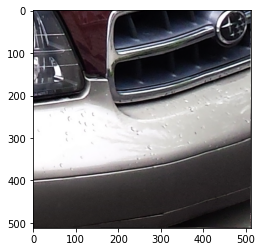

In [16]:
(a,b)=dummy_dataset.__getitem__(5)
print(a[0])
print(a.shape)
print(b)
print(b.shape)
plt.imshow(a[0])



In [17]:
def keras_model(length,input_size,output_classes):
        base_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=[length, length, 3])
        base_model.trainable = True
        inputs =tf.keras.layers.Input(shape=(length,length,3))
        x = tf.keras.applications.efficientnet.preprocess_input(inputs)
        x = base_model(x, training=True)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(32,activation='relu')(x)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)

        model =tf.keras.Model(inputs=inputs, outputs=outputs)

        model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

        model.summary() 
        return model

In [18]:
training_model = keras_model(length,length*length*3,10)

2021-12-04 06:03:28.653998: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 06:03:28.751190: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 06:03:28.751976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 06:03:28.753649: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

71696384/71686520 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 16, 16, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                57376     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 17,731,529
Trainable params: 17,606,322
Non-trainable params: 125,207
_________________________________________________________________


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [19]:
training_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
efficientnetb4 (Functional)  (None, 16, 16, 1792)      17673823  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1792)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                57376     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                330       
Total params: 17,731,529
Trainable params: 17,606,322
Non-trainable params: 125,207
_________________________________________________________________


In [20]:
xtrain,xval,ytrain,yval = train_test_split(training_data,classes,test_size=0.1,shuffle=True,random_state=seed)

In [21]:
print(len(xtrain),len(xval))
print(len(ytrain),len(yval))

2475 275
2475 275


In [22]:
training_dataset = Dataset(xtrain,ytrain,batch_size=batch_size,augmentations=training_transforms,test=False)
validation_dataset = Dataset(xval,yval,batch_size=1,augmentations=training_transforms,test=False)

print(len(training_dataset))
print(len(validation_dataset))

309
275


In [23]:
model_file = "output/base_model_weights.hd5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_accuracy", save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", verbose=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]


In [24]:
inner_epochs = 10
training_model.fit(training_dataset,validation_data=validation_dataset,epochs=inner_epochs,batch_size=batch_size,callbacks=callbacks_list,verbose=1)
loops = (epochs-inner_epochs)//inner_epochs
for i in range(0,loops):
    training_model= keras.models.load_model(model_file)
    training_model.fit(training_dataset,validation_data=validation_dataset,epochs=inner_epochs,batch_size=batch_size,callbacks=callbacks_list,verbose=1)

2021-12-04 06:03:38.324277: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-12-04 06:03:56.927659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


309/309 [==============================] - 706s 2s/step - loss: 1.8990 - accuracy: 0.3434 - val_loss: 2.3365 - val_accuracy: 0.0909


2021-12-04 06:15:49.662908: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/10
309/309 [==============================] - 672s 2s/step - loss: 1.1308 - accuracy: 0.6315 - val_loss: 2.3955 - val_accuracy: 0.0909
Epoch 3/10
309/309 [==============================] - 657s 2s/step - loss: 0.8024 - accuracy: 0.7367 - val_loss: 2.4078 - val_accuracy: 0.0909

Epoch 00003: ReduceLROnPlateau reducing learning rate to 8.999999772640876e-05.
Epoch 4/10
309/309 [==============================] - 654s 2s/step - loss: 0.6328 - accuracy: 0.7937 - val_loss: 2.4275 - val_accuracy: 0.0982


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 5/10
309/309 [==============================] - 660s 2s/step - loss: 0.5626 - accuracy: 0.8204 - val_loss: 2.4160 - val_accuracy: 0.0945
Epoch 6/10
309/309 [==============================] - 666s 2s/step - loss: 0.4936 - accuracy: 0.8443 - val_loss: 2.4999 - val_accuracy: 0.0909

Epoch 00006: ReduceLROnPlateau reducing learning rate to 8.100000122794882e-05.
Epoch 7/10
309/309 [==============================] - 654s 2s/step - loss: 0.4301 - accuracy: 0.8556 - val_loss: 2.5940 - val_accuracy: 0.1018


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 8/10
309/309 [==============================] - 669s 2s/step - loss: 0.4082 - accuracy: 0.8706 - val_loss: 2.4722 - val_accuracy: 0.0945
Epoch 9/10
309/309 [==============================] - 667s 2s/step - loss: 0.3656 - accuracy: 0.8786 - val_loss: 2.5235 - val_accuracy: 0.1055


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 10/10
309/309 [==============================] - 673s 2s/step - loss: 0.3521 - accuracy: 0.8867 - val_loss: 2.5795 - val_accuracy: 0.0982
Epoch 1/10
309/309 [==============================] - 707s 2s/step - loss: 0.3461 - accuracy: 0.8892 - val_loss: 2.5640 - val_accuracy: 0.0873
Epoch 2/10
309/309 [==============================] - 685s 2s/step - loss: 0.3206 - accuracy: 0.8932 - val_loss: 2.5506 - val_accuracy: 0.1018
Epoch 3/10
309/309 [==============================] - 675s 2s/step - loss: 0.2966 - accuracy: 0.9045 - val_loss: 2.5675 - val_accuracy: 0.0945
Epoch 4/10
309/309 [==============================] - 687s 2s/step - loss: 0.2725 - accuracy: 0.9094 - val_loss: 2.5836 - val_accuracy: 0.0800

Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-05.
Epoch 5/10
309/309 [==============================] - 689s 2s/step - loss: 0.2605 - accuracy: 0.9110 - val_loss: 2.5981 - val_accuracy: 0.0873
Epoch 6/10
309/309 [==============================] - 679s 2

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
309/309 [==============================] - 701s 2s/step - loss: 0.3165 - accuracy: 0.9037 - val_loss: 2.4918 - val_accuracy: 0.1055
Epoch 4/10
309/309 [==============================] - 707s 2s/step - loss: 0.2963 - accuracy: 0.9021 - val_loss: 2.5369 - val_accuracy: 0.0945

Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-05.
Epoch 5/10
309/309 [==============================] - 685s 2s/step - loss: 0.2593 - accuracy: 0.9179 - val_loss: 2.5689 - val_accuracy: 0.1018
Epoch 6/10
309/309 [==============================] - 687s 2s/step - loss: 0.2534 - accuracy: 0.9179 - val_loss: 2.5696 - val_accuracy: 0.1055

Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.56100019114092e-05.
Epoch 7/10
309/309 [==============================] - 701s 2s/step - loss: 0.2291 - accuracy: 0.9239 - val_loss: 2.5821 - val_accuracy: 0.0873
Epoch 00007: early stopping
Epoch 1/10
309/309 [==============================] - 731s 2s/step - loss: 0.2938 - accuracy: 0.

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 3/10
309/309 [==============================] - 704s 2s/step - loss: 0.2702 - accuracy: 0.9106 - val_loss: 2.5893 - val_accuracy: 0.0873
Epoch 4/10
309/309 [==============================] - 696s 2s/step - loss: 0.2580 - accuracy: 0.9183 - val_loss: 2.6144 - val_accuracy: 0.0909

Epoch 00004: ReduceLROnPlateau reducing learning rate to 7.289999848580919e-05.
Epoch 5/10
309/309 [==============================] - 712s 2s/step - loss: 0.2346 - accuracy: 0.9235 - val_loss: 2.6794 - val_accuracy: 0.0909
Epoch 6/10
309/309 [==============================] - 703s 2s/step - loss: 0.2233 - accuracy: 0.9264 - val_loss: 2.5454 - val_accuracy: 0.0909

Epoch 00006: ReduceLROnPlateau reducing learning rate to 6.56100019114092e-05.
Epoch 7/10
309/309 [==============================] - 708s 2s/step - loss: 0.2054 - accuracy: 0.9357 - val_loss: 2.5869 - val_accuracy: 0.1091
Epoch 00007: early stopping


In [25]:
sample_submission = pd.read_csv('/kaggle/input/sp-society-camera-model-identification/sample_submission.csv')
sample_submission.head()

,fname,camera
0,img_0002a04_manip.tif,iPhone-6
1,img_001e31c_unalt.tif,iPhone-6
2,img_00275cf_manip.tif,iPhone-6
3,img_0034113_unalt.tif,iPhone-6
4,img_00344b7_unalt.tif,iPhone-6


In [26]:
x_test = testing_path+sample_submission['fname']
#x_test = x_test.to_numpy()
print(x_test[0])

#training_model.load_model(model_file)
x_test = Dataset(x_test,x_test,test=True,batch_size=1,augmentations=testing_augmentation)

/kaggle/input/sp-society-camera-model-identification/test/test/img_0002a04_manip.tif


In [27]:
val_predicted = training_model.predict(validation_dataset)

In [28]:
training_model = tf.keras.models.load_model(model_file)
predicted = training_model.predict(x_test)

print(predicted)

[[0.11170471 0.1820334  0.05685028 ... 0.01426961 0.05811109 0.18206604]
 [0.11009254 0.2082085  0.0369486  ... 0.01572856 0.04228985 0.21514419]
 [0.13033712 0.16534255 0.05691778 ... 0.01826161 0.06474869 0.18175127]
 ...
 [0.15044259 0.14285879 0.07288914 ... 0.02046219 0.06916222 0.16346739]
 [0.11579394 0.15884358 0.07466587 ... 0.02637568 0.05814544 0.16873717]
 [0.11000973 0.17301326 0.05320366 ... 0.01685981 0.05854643 0.1712973 ]]


In [29]:

def convert_predictions_to_labels(labels):
    temp = []
    for item in labels.argmax(axis=1):
        temp.append(classes_dict[str(item)])
    return temp

In [30]:
test_labels = convert_predictions_to_labels(predicted)

validation_labels = convert_predictions_to_labels(val_predicted)

In [31]:
sample_submission['camera'] = test_labels
sample_submission.head()

,fname,camera
0,img_0002a04_manip.tif,iPhone-6
1,img_001e31c_unalt.tif,iPhone-6
2,img_00275cf_manip.tif,iPhone-6
3,img_0034113_unalt.tif,iPhone-6
4,img_00344b7_unalt.tif,iPhone-6


In [32]:
sample_submission.to_csv("submission.csv", index=False)

In [33]:
yval=yval.idxmax(axis=1)

In [34]:
con_matrix = confusion_matrix(yval,validation_labels)
print(con_matrix)

[[ 1  3  0  0  1  0  0  0  0 22]
 [ 1  2  0  0  0  0  0  0  0 20]
 [ 1  8  0  0  0  1  0  0  0 22]
 [ 1  6  0  0  1  0  0  0  0 17]
 [ 0  2  0  0  1  1  0  0  0 26]
 [ 0  0  0  0  0  0  0  0  0 25]
 [ 2  4  0  0  0  2  0  0  0 20]
 [ 1  6  0  0  0  2  0  0  0 19]
 [ 0  4  0  0  0  0  0  0  0 28]
 [ 0  5  0  0  0  2  0  0  0 18]]
